# import libraries

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import itertools  
import math
import itertools
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import LSTM, Embedding, Bidirectional
from keras.models import Model
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report 

import tensorflow as tf

Using TensorFlow backend.


## reading data to be trained

In [2]:
# reading data from csv files

path = r'C:\Users\91901\Code Here\CQA\dataset\Subtask C'

train_base = pd.read_csv(os.path.join(path,'TRAIN-BASE.csv'))
test_base = pd.read_csv(os.path.join(path,'TEST-BASE.csv'))
val_base = pd.read_csv(os.path.join(path,'VAL-BASE.csv'))

def read_df(df):
    f = df['feature'].tolist()
    x = df['question'].tolist()
    xx = df['answer'].tolist()
    y = df['labels'].tolist()
    return f, x, xx, y

f_train, x_train, xx_train, y_train = read_df(train_base)
f_test, x_test, xx_test, y_test = read_df(test_base)
f_val, x_val, xx_val, y_val = read_df(val_base)

# PRINT AND CHECK TRAINING, TESTING AND VALIDATION SET

print('\nTraining: ', len(f_train), len(x_train), len(xx_train), len(y_train)) #must be same
print('\nTesting: ', len(f_test), len(x_test), len(xx_test), len(y_test))
print('\nValidation: ', len(f_val), len(x_val), len(xx_val), len(y_val))


Training:  19990 19990 19990 19990

Testing:  7000 7000 7000 7000

Validation:  5000 5000 5000 5000


# UPSAMPLING (training, validation) and RE-MAKE all Test sets using train-test-split()

Upsampled Training Data and Validation Data. Combined these with given Test Data. Made new Training, Testing sets using sklearn. Validation Split 0.50 added in model.fit() 

In [3]:
# # SAMPLING ACCORDING TO LABELS 

feature_train, ques_train, ans_train, train_labels = f_train, x_train, xx_train, y_train
feature_test, ques_test, ans_test, test_labels = f_test, x_test, xx_test, y_test
feature_val, ques_val, ans_val, val_labels = f_val, x_val, xx_val, y_val


train_base = pd.DataFrame(
    {
    'feature':feature_train ,
    'question':ques_train,
    'answer':ans_train,
    'labels':train_labels
    })

test_base = pd.DataFrame(
    {
    'feature':feature_test ,
    'question':ques_test,
    'answer':ans_test,
    'labels':test_labels
    })

val_base = pd.DataFrame(
    {
    'feature':feature_val ,
    'question':ques_val,
    'answer':ans_val,
    'labels':val_labels
    })

In [4]:
# if one function for all train, test, validation 
def oversampling_function(base):

    bad_count, good_count, useful_count = base['labels'].value_counts()
    
    class_0 = base[base['labels'] == 'Bad']
    class_1 = base[base['labels'] == 'PotentiallyUseful']
    class_2 = base[base['labels'] == 'Good']

    ## print the shape of the class
    
    print('\n\nclass bad 0:', class_0.shape)
    print('class useful 1:', class_1.shape)
    print('class good 2:', class_2.shape)
    
    
    ## OVERSAMPLNG
    
    class_good = class_2.sample(bad_count, replace=True)
    class_useful = class_1.sample(bad_count, replace=True)

    oversampled_base = pd.concat([class_0, class_useful, class_good], axis = 0)
    print("Oversampled - Total class counts:\n", oversampled_base['labels'].value_counts())

#     print(oversampled_base['labels'].value_counts().plot(kind='bar', title = 'count (labels)'))

    return oversampled_base


print("Upsampling training Pool")
train_pool = oversampling_function(train_base)
val_pool = oversampling_function(val_base)
test_pool = test_base
#NEW TRAINING, TESTING, VALIDATION SET SIZES

print("\ntraining pool size after upsampling:", train_pool.shape)
print("\nvalidation pool size after upsampling:",val_pool.shape)
print("\ntesting pool size after upsampling:",test_pool.shape)

Upsampling training Pool


class bad 0: (16319, 4)
class useful 1: (1683, 4)
class good 2: (1988, 4)
Oversampled - Total class counts:
 Bad                  16319
PotentiallyUseful    16319
Good                 16319
Name: labels, dtype: int64


class bad 0: (4061, 4)
class useful 1: (594, 4)
class good 2: (345, 4)
Oversampled - Total class counts:
 Bad                  4061
PotentiallyUseful    4061
Good                 4061
Name: labels, dtype: int64

training pool size after upsampling: (48957, 4)

validation pool size after upsampling: (12183, 4)

testing pool size after upsampling: (7000, 4)


In [5]:
#combine train, validation
train_pool =  train_pool.append(val_pool, ignore_index = True) #combine train and validation pool
print("total training data now:\n ", len(train_pool))

total training data now:
  61140


In [6]:
# TRAINING, VALIDATION, TESTING SETS


frames = [train_pool, test_pool, val_pool]
BASE = pd.concat(frames)
BASE.shape
BASE.labels.value_counts()

#%%

a, b = train_test_split(BASE, test_size = 0.5)

f_train, x_train, xx_train, y_train = a['feature'], a['question'], a['answer'], a['labels']
f_test, x_test, xx_test, y_test = b['feature'], b['question'], b['answer'], b['labels']

# PRINT AND CHECK TRAINING, TESTING AND VALIDATION SET

print('\nTraining: ', len(f_train), len(x_train), len(xx_train), len(y_train)) #must be same
print('\nTesting: ', len(f_test), len(x_test), len(xx_test), len(y_test))



Training:  40161 40161 40161 40161

Testing:  40162 40162 40162 40162


# let's read and make embeddings for data

In [7]:
avg_feature_length = 10
avg_question_length = 20
avg_answer_length = 50
MAX_SEQUENCE_LENGTH = FINAL_SEQUENCE_LENGTH = 100

In [8]:
# FOR GLOVE VECTORS

def read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM):
    
    with open(os.path.join(GLOVE_DIR, 'glove.6B.'+ str(EMBEDDING_DIM)+'d.txt'),  encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


def pretrained_embedding_layer(word_to_vec_map, word_to_index, random_term):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map[random_term].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. 
    # Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

# GLOVE_DIR = 'glove.6B'
# GLOVE_DIR = r'C:\Users\NoBotsHere\codehere\CQACodes\qa_dataset\glove.6B'
GLOVE_DIR = r'C:\Users\91901\Code Here\CQA\dataset\glove.6B'

EMBEDDING_DIM = 50
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, "massage")

In [9]:
def generate_data_for_keras( t1, t2, t3, Y, 
                            word_index):

    t1_sequences = [] #first vector 
    t2_sequences = [] #second vector
    t3_sequences = [] #three vector

    for t1_keys in t1:
        t1_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t1_keys.lower().split()])
    
    for t2_keys in t2:
        t2_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t2_keys.lower().split()])
    
    for t3_keys in t3:
        t3_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t3_keys.lower().split()])
           
    # padding 
    # long sentences truncated to maxlen (last sequences are kept)
    # short sentences padded with 0 (pad are added at begining)
    t1_data = pad_sequences(t1_sequences, maxlen= avg_feature_length, padding='post')  
    t2_data = pad_sequences(t2_sequences, maxlen= avg_question_length, padding='post') 
    t3_data = pad_sequences(t3_sequences, maxlen= avg_answer_length, padding='post') 

    print('\nShape of question text data tensor:', t2_data.shape)
    print('\nShape of answer text data tensor:', t3_data.shape)
    print('\nShape of feature text data tensor:', t1_data.shape)
 
    
    y = []
    
    for t in Y:    
        if t =='Bad':
            y.append(0)
        elif t =='Good':
            y.append(2)
        elif t == 'PotentiallyUseful':
            y.append(1)
    
       
    label = np.array(y)
    print('\nShape of label data tensor:', label.shape)
    print('\nlabel data:', label)
    
    return t1_data, t2_data, t3_data, label


# # data for keras layers
#T1 IS FIRST TEXT FEATURE TEXT
#T2 IS QUESTION TEXT 
#T3 IS ANSWER TEXT
print('\nTraining: ') 
t1_train, t2_train, t3_train, y_train  = generate_data_for_keras(f_train, x_train, xx_train, y_train, word_to_index)

print('\nTesting: ')
t1_test, t2_test, t3_test, y_test  = generate_data_for_keras(f_test, x_test, xx_test, y_test, word_to_index)

print('\nTraining: ', len(t1_train), len(t2_train), len(t3_train), len(y_train)) #must be same
print('\nTesting: ', len(t1_test), len(t2_test), len(t3_test), len(y_test))



Training: 

Shape of question text data tensor: (40161, 20)

Shape of answer text data tensor: (40161, 50)

Shape of feature text data tensor: (40161, 10)

Shape of label data tensor: (40161,)

label data: [2 0 1 ... 1 0 0]

Testing: 

Shape of question text data tensor: (40162, 20)

Shape of answer text data tensor: (40162, 50)

Shape of feature text data tensor: (40162, 10)

Shape of label data tensor: (40162,)

label data: [0 2 1 ... 0 2 0]

Training:  40161 40161 40161 40161

Testing:  40162 40162 40162 40162


In [10]:
# DISPLAY training, testing and validation data 

print('------- Training Data -------\n')
for i in range (2):
    print ('Entry:', t1_train[i] , '\n', t2_train[i] , '\n', t3_train[i] , '\nLabel:' , y_train[i], '\n')
      
print('------- Testing Data -------\n')
for i in range (2):
    print ('Entry:', t1_test[i] , '\n', t2_test[i] , '\n', t3_test[i] , '\nLabel:' , y_test[i], '\n')


------- Training Data -------

Entry: [ 98970 315390 322860      0      0      0      0      0      0      0] 
 [185457  90548  87972 357388 357640  87775  52520 389453 186645 185457
 329916  84236 386307 185457 174642 270970  87972 357640    867      0] 
 [343964 176573 141816 269953 281904 305224 360915 351935 357266 359889
 360915 374163      0      0 383514 390093      0 357266 164328      0
 175199 385595 269798 360915 106326 179434 119560 154323      0 185457
 217787 175426 175199 383514 188481 218524 321160 388711 181598 268046
  71587  43010 218608 339019 188481 119292 308625 151349 357266      0] 
Label: 2 

Entry: [126552 192439 188481 296552 105625      0      0      0      0      0] 
 [270970 380430 126848 193716 105625 372383 336114 357212 394475  90548
 374163 193716 388711  56041 325758 294047 386424 394475 364331      0] 
 [185457  90548  61257 390123 185457 383068 177231      0  54718 186645
 369052      0 209645 357412 219178 193716 151349 280944 357212 126552
 209645

# Preparing Contextualized Embeddings

In [12]:
%%time

# Prepare embeddings sequences by initializing keras embedding layer with glove embedding values

sequence_input_feat = Input(shape=(avg_feature_length,), dtype='int32', name='featureLayer')
embedded_feat_sequences = embedding_layer(sequence_input_feat)
      
sequence_input_ques = Input(shape=(avg_question_length,), dtype='int32', name='questionLayer')
embedded_ques_sequences = embedding_layer(sequence_input_ques)


sequence_input_ans = Input(shape=(avg_answer_length,), dtype='int32', name='answerLayer')
embedded_ans_sequences = embedding_layer(sequence_input_ans)

Wall time: 16 ms


In [ ]:
%%time

def bilstm_embeddings(embedded_sequences):

   
    n = Bidirectional(LSTM(nn_units, return_sequences= True, 
                            name = 'bilstm_layer', dropout = dropout_inputs, 
                            recurrent_dropout = recurrent_dropout_inputs))(embedded_sequences)

    return n

# Model definition for Classification


In [14]:
# default helpful

INPUT_SEQUENCES = [sequence_input_feat, sequence_input_ques, sequence_input_ans]
TRAIN_FIT = [t1_train, t2_train, t3_train]

In [15]:
# defining model

def classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES):
    
    # FOR MODEL_1 
    
    FinalLayer = keras.layers.concatenate(inputs = INPUT_EMBEDDINGS, axis = 1)
    FinalLayer = keras.layers.GlobalAveragePooling1D()(FinalLayer)
    predictions = Dense(3, activation = "softmax")(FinalLayer)

    # MODEL_1 FOR ANSWER SELECTION

    model = Model(inputs = INPUT_SEQUENCES , outputs = predictions)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
    
    model.summary()

    return model

# Common functions - Plot, Evaluate, Save Results

# Training Model

In [16]:
def training_model(model, MODEL_NAME, TRAIN_FIT):
    

    callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)
    checkpoint_path = os.path.join(MODEL_NAME + '_checkpoint.h5')

    modelcheck_acc = ModelCheckpoint(checkpoint_path, 
                                     monitor='acc', mode='max', 
                                    save_best_only = True, verbose=1)

    CALLBACK = [callback, modelcheck_acc]

    history = model.fit(TRAIN_FIT, y_train, 
                            batch_size = batchsize, 
                            epochs = epochs_count, 
                            validation_split = 0.50, 
                            callbacks = CALLBACK
                           )
    return history

In [17]:
# into files save
  
# model_directory = "Resulting Model"
# MODEL_SAVING_DIR = os.path.join(path, model_directory)
# os.mkdir(MODEL_SAVING_DIR) 
 
# MODEL_SAVING_DIR = (r'\folder-path')

def save_models(model, MODEL_NAME):
  
    # serialize model to JSON
    model_json = model.to_json()
    with open(MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(MODEL_NAME + ".h5")
    print("\nTHIS MODEL HAS BEEN SAVED TO DIRECTORY: ", os.getcwd())

In [18]:
def plot_graphs(history, string):
    print('training of model')
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [19]:
def plot_both_graphs(history):
    # plot train and validation loss
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # plot train and validation loss
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model train vs validation acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    

In [20]:
def evaluate_model(model):
    # Returns the loss value & metrics values for the model in test mode.
    print("Evaluated on metrics ", model.metrics_names)

    score_loss, score_acc = model.evaluate([t1_test, t2_test, t3_test], y_test, batch_size=batchsize)
    print("Test Loss :", score_loss, "Test Accuracy: ", score_acc)

    # MODEL_1 FOR PREDICTIONS 
    model_predictions = model.predict([t1_test, t2_test, t3_test])
    print("\npredictions shape is: ", model_predictions.shape)
#     print("\nand few predictions are:\n", model_predictions[:3], "\n\n while original test labels look like: ", y_test[:10])

    #To find the predicted class for each test example, you need to use axis=1
    predicted_class_names = np.argmax(model_predictions, axis = 1)
    print("\n\n Predictions into Class Labels:", predicted_class_names)

    print("\n\n METRICS CLASSIFICATION REPORT IS:\n", classification_report (y_test, np.argmax(model_predictions, axis = 1)))
    
    return model_predictions, predicted_class_names

In [21]:
def result_store(predicted_class_names):
    
    df = pd.DataFrame(columns = ['feature', 'text_1', 'text_2', 'true_label'])
    df['feature'] = f_test
    df['text_1'] = x_test
    df['text_2'] = xx_test
    df['true_label'] = y_test
    df['predicted_label'] = predicted_class_names

    return df

In [22]:
## put into files these 


# df_true_labels = pd.DataFrame(y_test, columns = ['y_test_labels'])
# df_true_labels.y_test_labels.value_counts()
# df_true_labels.head()

# df_pred_labels = pd.DataFrame(predicted_class_names_1, columns = ['y_pred_labels'])
# df_pred_labels.y_pred_labels.value_counts()
# df_pred_labels.head()

# print("no of true labels:\n", df_true_labels.y_test_labels.value_counts())
# print("no of predicted labels:\n", df_pred_labels.y_pred_labels.value_counts())

## Model_bilstm for Classification

In [13]:
# define parameters 

nn_units = 128
dropout_inputs = 0.2
recurrent_dropout_inputs = 0.15
batchsize = 64
epochs_count = 100

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_1/concat:0", shape=(None, 10, 256), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(None, 20, 256), dtype=float32)
Tensor("bidirectional_3/concat:0", shape=(None, 50, 256), dtype=float32)
Wall time: 1.33 s


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
answerLayer (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

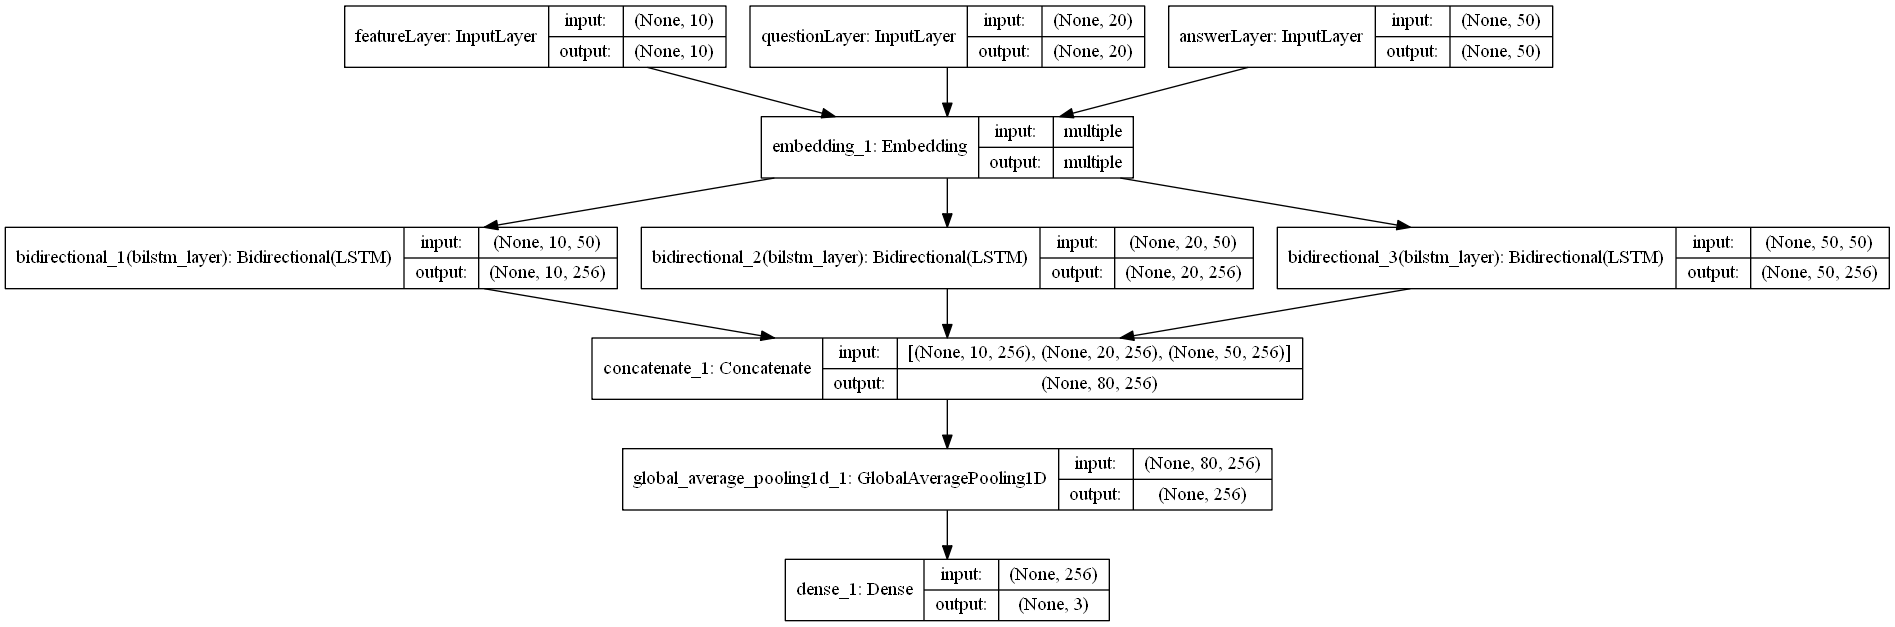

In [23]:
#CUSTOM COLUMNS

INPUT_EMBEDDINGS = [n1, n2, n3]

model_bilstm = classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_bilstm, to_file = 's2-model_bilstm.png', show_shapes=True, show_layer_names=True)

In [24]:
history_bilstm = training_model(model_bilstm, 's2-model-bilstm', TRAIN_FIT) 
save_models(model_bilstm, 's2-model-bilstm')

Train on 20080 samples, validate on 20081 samples
Epoch 1/100
20080/20080 [==============================] - 39s 2ms/step - loss: 1.0185 - acc: 0.4822 - val_loss: 0.9685 - val_acc: 0.5280

Epoch 00001: acc improved from -inf to 0.48222, saving model to s2-model-bilstm_checkpoint.h5
Epoch 2/100
20080/20080 [==============================] - 32s 2ms/step - loss: 0.9468 - acc: 0.5439 - val_loss: 0.9311 - val_acc: 0.5575

Epoch 00002: acc improved from 0.48222 to 0.54387, saving model to s2-model-bilstm_checkpoint.h5
Epoch 3/100
20080/20080 [==============================] - 32s 2ms/step - loss: 0.9146 - acc: 0.5696 - val_loss: 0.8684 - val_acc: 0.6031

Epoch 00003: acc improved from 0.54387 to 0.56962, saving model to s2-model-bilstm_checkpoint.h5
Epoch 4/100
20080/20080 [==============================] - 32s 2ms/step - loss: 0.8859 - acc: 0.5878 - val_loss: 0.8850 - val_acc: 0.5772

Epoch 00004: acc improved from 0.56962 to 0.58785, saving model to s2-model-bilstm_checkpoint.h5
Epoch 5/1

20080/20080 [==============================] - 31s 2ms/step - loss: 0.2872 - acc: 0.8933 - val_loss: 0.4565 - val_acc: 0.8598

Epoch 00071: acc improved from 0.89089 to 0.89328, saving model to s2-model-bilstm_checkpoint.h5
Epoch 72/100
20080/20080 [==============================] - 31s 2ms/step - loss: 0.2921 - acc: 0.8896 - val_loss: 0.4725 - val_acc: 0.8540

Epoch 00072: acc did not improve from 0.89328
Epoch 73/100
20080/20080 [==============================] - 31s 2ms/step - loss: 0.2871 - acc: 0.8926 - val_loss: 0.4776 - val_acc: 0.8538

Epoch 00073: acc did not improve from 0.89328
Epoch 74/100
20080/20080 [==============================] - 31s 2ms/step - loss: 0.2835 - acc: 0.8938 - val_loss: 0.4631 - val_acc: 0.8597

Epoch 00074: acc improved from 0.89328 to 0.89382, saving model to s2-model-bilstm_checkpoint.h5
Epoch 75/100
20080/20080 [==============================] - 31s 2ms/step - loss: 0.2754 - acc: 0.8976 - val_loss: 0.4652 - val_acc: 0.8570

Epoch 00075: acc improved f

In [55]:
print(history_bilstm.history['loss'][-1])
print(history_bilstm.history['acc'][-1])

0.2312074806348261
0.91518927


training of model


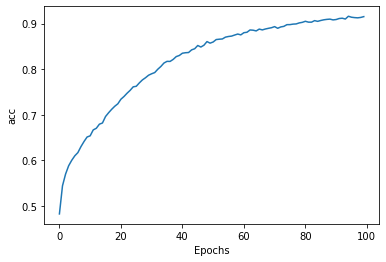

training of model


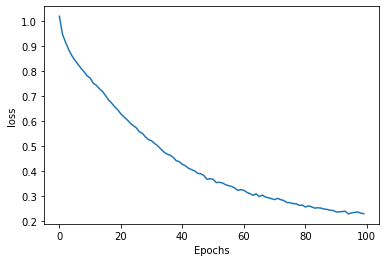

In [25]:
plot_graphs(history_bilstm, 'acc')
plot_graphs(history_bilstm, 'loss')

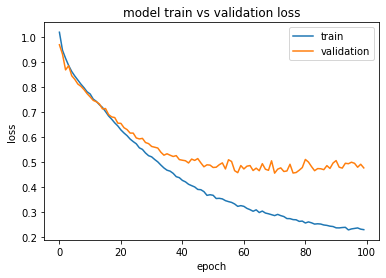

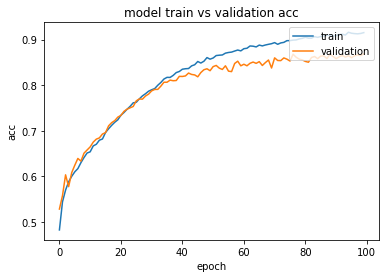

In [26]:
plot_both_graphs(history_bilstm)

In [27]:
model_predictions_bilstm, predicted_class_names_bilstm = evaluate_model(model_bilstm)

Evaluated on metrics  ['loss', 'acc']
40162/40162 [==============================] - 12s 308us/step
Test Loss : 0.48444085461074304 Test Accuracy:  0.867835283279419

predictions shape is:  (40162, 3)


 Predictions into Class Labels: [0 0 1 ... 1 2 0]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86     15170
           1       0.83      0.89      0.86     12501
           2       0.86      0.90      0.88     12491

    accuracy                           0.87     40162
   macro avg       0.87      0.87      0.87     40162
weighted avg       0.87      0.87      0.87     40162



In [28]:
result_bilstm = result_store(predicted_class_names_bilstm)

print("no of true labels:\n", result_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_bilstm.predicted_label.value_counts())

result_bilstm.head()

no of true labels:
 0    15170
1    12501
2    12491
Name: true_label, dtype: int64
no of predicted labels:
 0    13753
1    13368
2    13041
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
50245,Who is the founder?,who is the founder of Qatar Living?how many me...,It is always the lost that need my guidance,0,0
4600,QLing after working hours,how many of you logon to QL after your working...,zero..........,2,0
22743,Red Light Cameras,Hi; Today I made a mistake of crossing an oran...,i don know what u mean by 'how accurate' but y...,1,1
4,Massage oil,Where I can buy good oil for massage?,Yes Lawa...you couldn't be more right LOL,0,1
45225,Beauty Salon,Pls recomend a good ladies beauty salon;; in d...,go to falcon salon at al nasr street they good...,2,2


In [43]:
result_bilstm.sort_index()

,feature,text_1,text_2,true_label,predicted_label
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
...,...,...,...,...,...
61127,How can I sponsor my husband?,Hi there; Does any of you know what are the cr...,Yes; he can work under wife's sponsorship... b...,2,2
61128,What is the best place now in Qatar?,What is the best place now in Qatar to spend t...,Corniche near sheraton hotel; but weather is n...,2,2
61129,How can I sponsor my husband?,Hi there; Does any of you know what are the cr...,Minimum of QR7K to be able for you to be under...,2,2
61130,Sandy beaches,We now feel ready to explore Qatar and was won...,get taxi or ask somobody to drive you to seali...,2,2


In [ ]:
results_path = os.getcwd()
result_bilstm.to_csv(os.path.join(results_path,'s2-FQA-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

# Saving Experiment Details

    data description train-fit
    Parameters hidden units, dropouts, batchsize
    Model Description optimizer, activation, no of lstms, metrics
    Performance details training val test loss accuracy
    True vs Pred result.truelabel column and predictedlabel column
    

In [ ]:
# parameter_details = {
#     'nn_units' : nn_units,
#     'dropout_inputs' 
# recurrent_dropout_inputs 
# batchsize 
# epochs_count 

# dropout_inputs 
# recurrent_dropout_inputs 
# batchsize 
# epochs_count 
    
# ]

# df_perf = pd.DataFrame(columns = ['model_name'])


# print(history_bilstm.history['loss'][-1])
# print(history_bilstm.history['acc'][-1])

# Stacked Model

In [ ]:
# define parameters for stacked

nn_units = 64
dropout_inputs = 0.3
recurrent_dropout_inputs = 0.2
batchsize = 32
epochs_count = 80

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

In [30]:
%%time


# call for stacked embeddings

def stacked_bilstm_embeddings(layer):
    
    for i in range(4):
#         print('run:', i, '--', 'layer-name:', layer)
        layer = Bidirectional(LSTM(nn_units, return_sequences= True, name = 'bilstm_layer', 
                        dropout=dropout_inputs, recurrent_dropout = recurrent_dropout_inputs))(layer)
    
    return layer

stacked_n1 = stacked_bilstm_embeddings(n1)
stacked_n2 = stacked_bilstm_embeddings(n2)
stacked_n3 = stacked_bilstm_embeddings(n3)

print(stacked_n1)
print(stacked_n2)
print(stacked_n3)

Tensor("bidirectional_7/concat:0", shape=(None, 10, 128), dtype=float32)
Tensor("bidirectional_11/concat:0", shape=(None, 20, 128), dtype=float32)
Tensor("bidirectional_15/concat:0", shape=(None, 50, 128), dtype=float32)
Wall time: 5.74 s


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
answerLayer (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

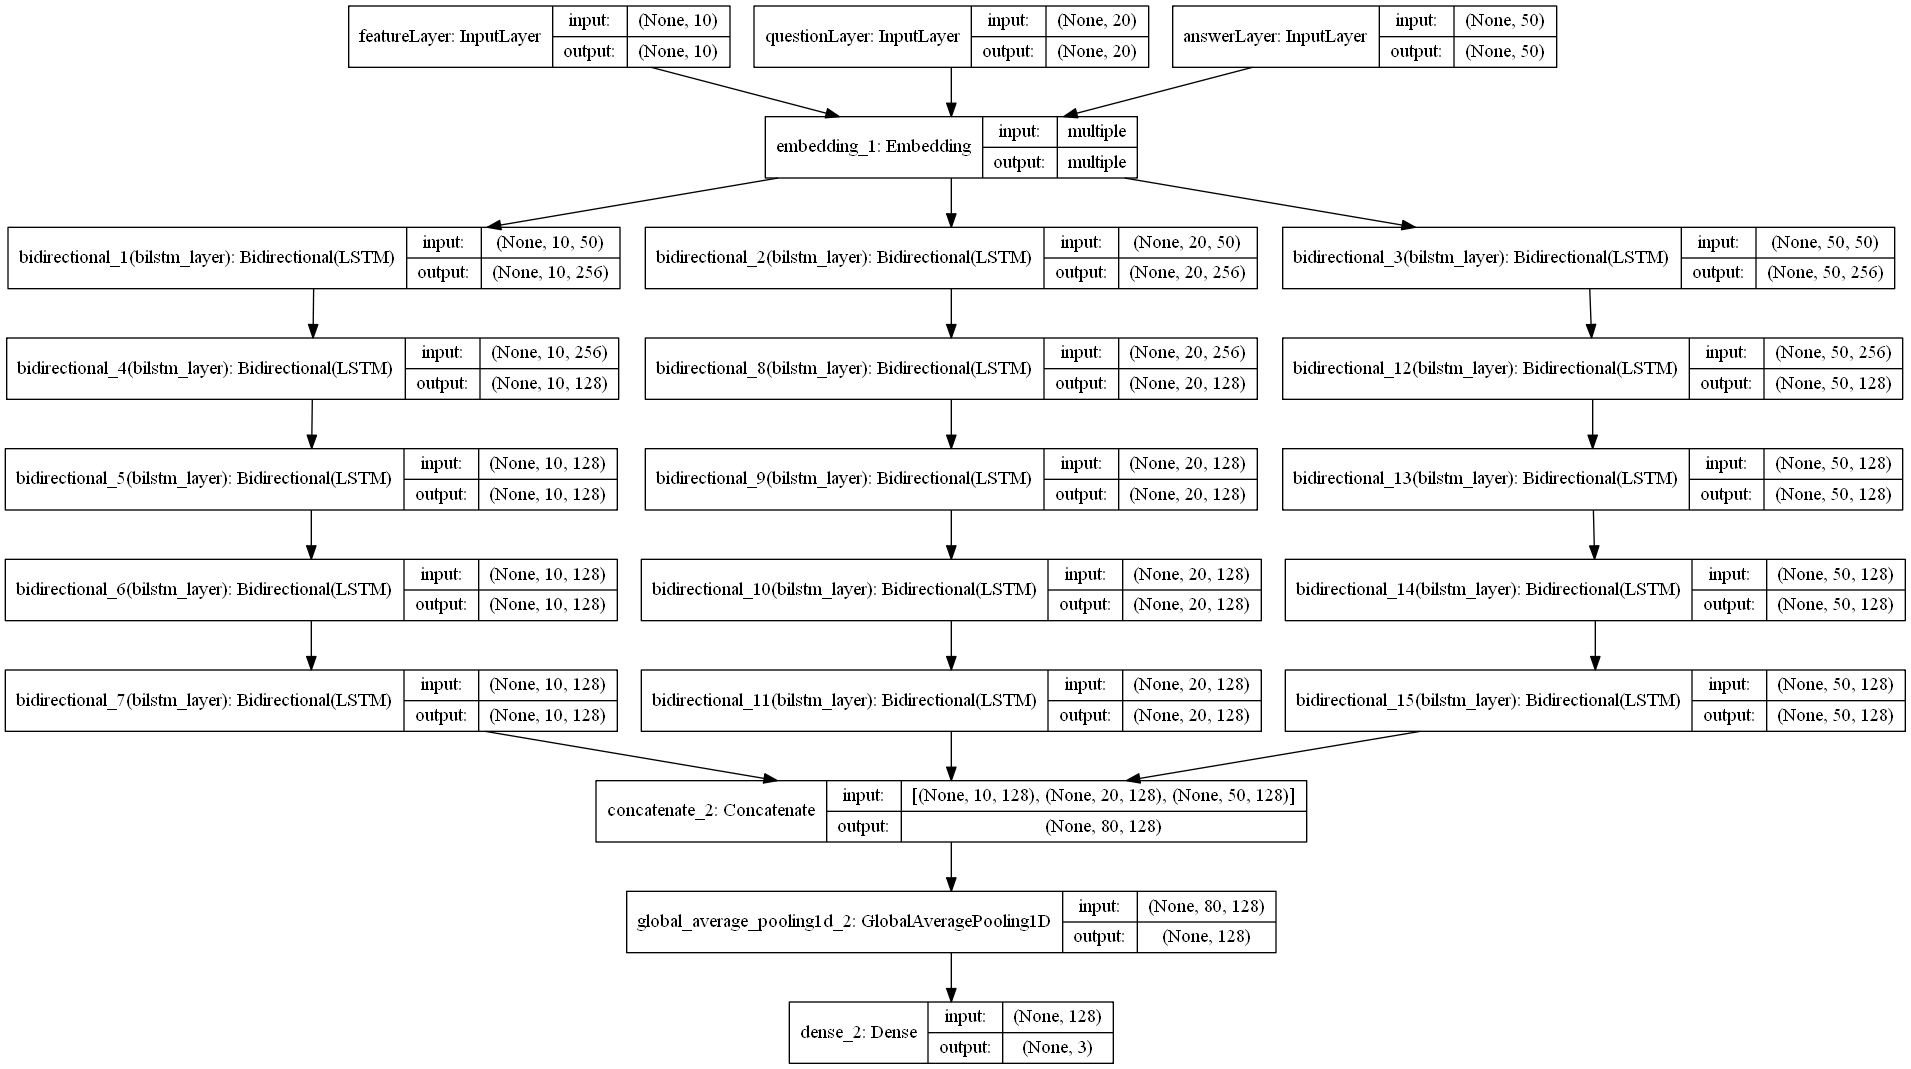

In [31]:
STACKED_EMBEDDINGS = [stacked_n1, stacked_n2, stacked_n3]

model_stacked_bilstm = classification_model(STACKED_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_stacked_bilstm, to_file = 's2-model_stacked_bilstm.png', show_shapes=True, show_layer_names=True)

In [32]:
history_stacked_bilstm = training_model(model_stacked_bilstm, 's2-model-stacked-bilstm', TRAIN_FIT) 

Train on 20080 samples, validate on 20081 samples
Epoch 1/150
20080/20080 [==============================] - 257s 13ms/step - loss: 0.3784 - acc: 0.8549 - val_loss: 0.5140 - val_acc: 0.8410

Epoch 00001: acc improved from -inf to 0.85493, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 2/150
20080/20080 [==============================] - 249s 12ms/step - loss: 0.3130 - acc: 0.8839 - val_loss: 0.5450 - val_acc: 0.8532

Epoch 00002: acc improved from 0.85493 to 0.88386, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 3/150
20080/20080 [==============================] - 246s 12ms/step - loss: 0.3029 - acc: 0.8868 - val_loss: 0.5632 - val_acc: 0.8410

Epoch 00003: acc improved from 0.88386 to 0.88675, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 4/150
20080/20080 [==============================] - 245s 12ms/step - loss: 0.2859 - acc: 0.8938 - val_loss: 0.4989 - val_acc: 0.8485

Epoch 00004: acc improved from 0.88675 to 0.89382, saving model to s2-mode

In [33]:
save_models(model_stacked_bilstm, 's2-model_stacked_bilstm')


THIS MODEL HAS BEEN SAVED TO DIRECTORY:  C:\Users\91901\Code Here\CQA\1 go-to files functions\sampling-models


training of model


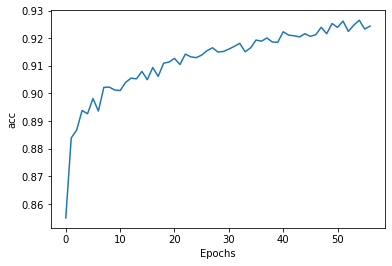

training of model


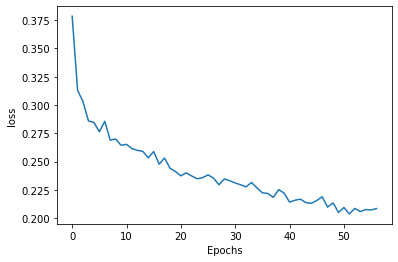

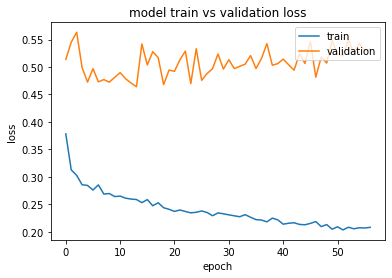

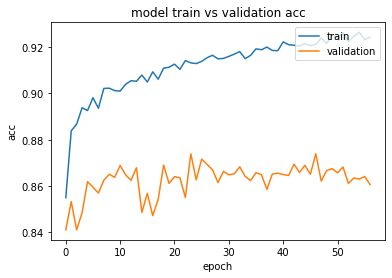

In [34]:
plot_graphs(history_stacked_bilstm, 'acc')
plot_graphs(history_stacked_bilstm, 'loss')
plot_both_graphs(history_stacked_bilstm)

In [35]:
model_predictions_stacked_bilstm, predicted_class_names_stacked_bilstm = evaluate_model(model_stacked_bilstm)

Evaluated on metrics  ['loss', 'acc']
40162/40162 [==============================] - 75s 2ms/step
Test Loss : 0.5365295233981797 Test Accuracy:  0.8567302227020264

predictions shape is:  (40162, 3)


 Predictions into Class Labels: [0 2 1 ... 1 2 2]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.92      0.78      0.84     15170
           1       0.83      0.89      0.86     12501
           2       0.83      0.92      0.87     12491

    accuracy                           0.86     40162
   macro avg       0.86      0.86      0.86     40162
weighted avg       0.86      0.86      0.86     40162



In [44]:
result_stacked_bilstm = result_store(predicted_class_names_stacked_bilstm)

print("no of true labels:\n", result_stacked_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_stacked_bilstm.predicted_label.value_counts())

result_stacked_bilstm.head()

no of true labels:
 0    15170
1    12501
2    12491
Name: true_label, dtype: int64
no of predicted labels:
 2    13848
1    13422
0    12892
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
50245,Who is the founder?,who is the founder of Qatar Living?how many me...,It is always the lost that need my guidance,0,0
4600,QLing after working hours,how many of you logon to QL after your working...,zero..........,2,2
22743,Red Light Cameras,Hi; Today I made a mistake of crossing an oran...,i don know what u mean by 'how accurate' but y...,1,1
4,Massage oil,Where I can buy good oil for massage?,Yes Lawa...you couldn't be more right LOL,0,1
45225,Beauty Salon,Pls recomend a good ladies beauty salon;; in d...,go to falcon salon at al nasr street they good...,2,2


In [45]:
results_path = os.getcwd() 
result_stacked_bilstm.to_csv(os.path.join(results_path,'s2-FQA-STACKED-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

In [46]:
t = result_stacked_bilstm.sort_index()

In [47]:
t.head(50)

,feature,text_1,text_2,true_label,predicted_label
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,Good Bank,Which is a good bank as per your experience in...,Commercial bank/IBQ,2,2
0,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",Are you Qatari? That may be the answer.,1,0
1,Good Bank,Which is a good bank as per your experience in...,The best bank in Qatar for you would be the on...,2,2
1,Good Bank,Which is a good bank as per your experience in...,The best bank in Qatar for you would be the on...,2,2
1,Good Bank,Which is a good bank as per your experience in...,The best bank in Qatar for you would be the on...,2,2
1,Good Bank,Which is a good bank as per your experience in...,The best bank in Qatar for you would be the on...,2,2
